# **LAB 3.** Visual Transformers

**Let's start with downloading libraries we did not have on the previous lab.**

In [ ]:
!pip install transformers
!pip install datasets
!pip install --quiet evaluate

In [ ]:
# Pytorch part
import torch
import torch.nn as nn
import torch.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as f

# Hugging Face part
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, AutoImageProcessor

# Other libraries
import random
import evaluate
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

# Disabling WANDB
import wandb
wandb.init(mode='disabled')

# Motivation

Let's start from basics. In NLP area we are basically dealing with sequences of tokens (e.g. words or text chunks) that form sentences or text with some length. From that perspecrtive we want to create a model that can generate or continue our sequence. Specifically **statistical models** stands behind modern complex large language models and idea of generating sequences of different length. This is how looks Markov chain model that can help us calculate probability of some sequence (e.g. sentence)

$$P(w_{1}, w_{2},...,w_{N})=P(w_{N}∣w_{1},w_{2},...,w_{N−1})×P(w_{1},w_{2},...,w_{N−1})=P(w_{N}∣w_{1},w_{2}​,...,w_{N−1})×P(w _{N−1}∣w_{1}​,w_{2},...,w_{N−2}×..×P(w_{2}∣w_{1})×P(w_{1}​)$$
, where $w_{i}$ - prob. of word, $P(w_{1}, w_{2},...,w_{N})$ - prob. of our sentence.

Problem? **We do not have an underlying distribution.** Especially for such complex structures as words. It is usually approximated on the basis of **a corpus of texts** (for example, the entire Internet) - in this case, the co-occurrences of words with each other are calculated, and the probabilities are calculated based on them.

BUT: we take a context with some length N-1 as it is impossible to preserve all the possible context of each word. It limits our word generation due to inability of working with long sequences.

As the next evolution in architectures there were:
- **Recurrent Neural Networks (RNN)** - applicable for time-series data cases without need of long-term dependency

<img src="https://i.postimg.cc/KzWMMWg9/RNN.png" width="500" height="200">


- **Long Short Term Memory (LSTM) Networks** - evolution of RNN capable of working with a long sequence

<img src="https://i.postimg.cc/jdBYF4yZ/LSTM.png" width="500" height="200">

Can you explain the difference and properties of each architecture?

[RNN and LSTM EXPLANATION](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) - **RECOMMENDED!**


# Transformers

Before swtichng to transformers, let's recall why do we need **Attention mechanism** that is considered as a architectural basement for modern LLMs?


As you might know specifically transformers defined the most progress in many ML tasks in recent years. This is an regular look of the architecture from the famous [article](https://arxiv.org/pdf/1706.03762), where Transforemr was presented for the 1st time.

<img src="https://i.postimg.cc/9fvyrMwy/transformers.webp" width="400" height="500">


Originally it  consists of two main architecturial units: **encoder (left)** and **decoder (right)**. Some other variations could be based only on one element (e.g. [BERT](https://arxiv.org/pdf/1810.04805), ViT). Let's briefly remind what stands behind them.

The `encoder` consists of N blocks that is applied in turn to the initial sequence. Each block outputs a sequence of the same length. It contains two important layers: **multi-head attention** and **feed-forward**. After each layer, the input is added to the output (how do we call it?), and then the activations are passed through a layer normalization layer, which is labeled as **"Add & Norm"** on the figure below.


<img src="https://yastatic.net/s3/education-portal/media/ml_transformery_1_c190108d7e_0cf50c39c9.svg" width="400" height="200">

From the code perspective it would look like this.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = nn.MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.self_attn(self.norm1(x))
        x = x + self.feed_forward(self.norm2(x))
        return x

The `decoder` part looks almost identical, the main difference is that inside N blocks we have **two** multi-head attention layers, where one of which uses output of the encoder.

Try to complete architecture by yourself... And then you can [check](https://www.geeksforgeeks.org/deep-learning/transformer-using-pytorch/) and compare your realization.

In [ ]:

# ---------------------------

# **YOUR CODE**

# ---------------------------

Next let's dive into **Attention**, which we can consider as a backbone of the architecture.

First, **self-attention** is used to weigh the importance of tokens or words in an input sequence to better understand the relations between them. An input sequence is a series of data points vectorized into **embeddings**, or numerical representations, that the machine learning algorithm can use to calculate attention scores needed to produce an output sequence. The embeddings are used to calculate the attention weights that help the model prioritize (or attend to) the most relevant input data.


Then, using embeddings **three** trainable matrices $W_{Q}, W_{K}, W_{V}$ will be involved in calculating the attention. The representation $x_{i}$ of each element of the input sequence is multiplied by $W_{Q}, W_{K}, W_{V}$, obtaining row vectors $q_{i}, k_{i}, v_{i}$ (where i is the element number), which are called **queries, keys, and values** respectively. Let's explain role each of them:

*   $q_{i}$ — query to the database
*   $k_{i}$ — keys of the values stored in the database to make a search
*   $v_{i}$ — values in the database

The attention operation can be thought of as a retrieval process of most related word in the sentence. To make this happen we can use basic mathematical operations.

On the image below think of the **MatMul** as an inquiry system that processes the inquiry: "For the word q in the given sentence, what is the most related word k in the sentence to understand what q is about?" The inquiry system provides the answer as the probability.

The calculation goes like this:



1.   Picks up a word vector (position encoded) from the input sentence sequence, and transfer it to a vector space Q. This becomes the query.

$𝑄=𝑋⋅𝑊^{𝑇}_{𝑄}$


2.   Pick all the words in the sentence and transfer them to the vector space K. They become keys and each of them is used as key.

$K=𝑋⋅𝑊^{𝑇}_{K}$

3. For each (q, k) pair, their relation strength is calculated using dot product.

q_to_k_similarity = MatMul($Q,K^{𝑇}$)

**NOTE:** Weight matrices $W_{Q}$ and $W_{K}$ are trained via the back propagations during the Transformer training.

4. Second MatMul is an output of our encoder, which is our **attention value.** It generates the embedding vector called attention value (as a bag of words (BoW)) where each word contributes proportionally according to its relationship strength to q.

**self-attention(Q, K, V)** = $softmax(\frac{QK^{T}}{\sqrt(d_{k})})V$

<img src="https://i.postimg.cc/50gZMcQT/Attention.png" width="800" height="400">

On this stage we already can use those attention scores to solve some problems (using as features). However if we want to generate something - we have a decoder, which in  classical transformer has something called **a cross-attention**.

In the decoder, one of the attention layers is a cross-attention layer, in which queries are taken from the output sequence, and keys and values ​​are taken from the input sequence (that is, from the results of the encoder).

<img src="https://yastatic.net/s3/education-portal/media/decoder_attention_03be436fa1_b4c942b0ae.webp" width="400" height="200">

The second part of the transformer block applies feed-forward network (FFN) that consists of two conventional fully connected layers applied independently to each element of the input sequence. In recent architectures, the size of the intermediate representation (i.e., the output of the first layer) can be quite large—four times larger than the block outputs.


$FFN(x)=act(xW_{1}+b_{1})W_{2}+b_{2}$,

where *act* - activation function (could be ReLU, but more often it is GELU)


Additional elements in architecture:

- Layer Nomalization
- Residual Connections
- Positional Embedding


 **Multi-Head Attention** is a crucial extension of self-attention that enhances this primary functionality by attending to different elements within the input dataset simultaneously. Models can attend to distinct aspects or relationships in the data at once, allowing for more context to be drawn between dependencies or tokens.

 Formally, this layer is written in terms of the following transformations:


![](https://habrastorage.org/getpro/habr/upload_files/6f5/6a7/56f/6f56a756ff0f1bf515432e682ca1639a.svg)

![](https://habrastorage.org/getpro/habr/upload_files/ff3/a9f/64f/ff3a9f64f8df2adffe643b504e699771.svg)

WHERE

![](https://habrastorage.org/getpro/habr/upload_files/f50/594/979/f50594979e5b53ae125646961ba01755.svg)



[TRANSFORMER (FULL EXPLANATION)](https://jalammar.github.io/illustrated-transformer/) - **RECOMMENDED!**

# Visual Transformer

**The Vision Transformer (ViT)** architecture is a deep learning model that applies the self-attention mechanism from Natural Language Processing (NLP) directly to computer vision tasks, without using traditional convolution operations.

It treats an image as a sequence of discrete patches, similar to how an NLP model processes a sequence of words. For each patch, the patch is pushed through **a linear operator**, to obtain a vector ("patch embedding") - **code below**. The position of the patch is also transformed into a vector by "position encoding". The two vectors are added, then pushed through several Transformer encoders.

Compared to CNNs, ViTs are less data efficient, but have higher capacity.


<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg" width="800" height="400">

Additional sources about ViT:

https://habr.com/ru/companies/otus/articles/849756/

In [ ]:
class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 1, 60, 100),
                patch_size: int=50,
                token_len: int=768):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        x = self.split(x).transpose(1,0)
        x = self.project(x)
        return x

Ok, that's it about background and theory, let's switch to the practical side.

In this lab session we will go through the most advanced type of computer vision - Transformer-based architecture called Visual Transformer (VT). Specifically we will make practical comparison between CNN and VT models. Our main goal is to get throgh practical application and apply a latter architecture for a practical example (e.g. classification task).

Usually we associate VT models with big pretrained models that consist of millions (or even billions) of parameters making it almost infeasible to train in "home" conditions. In that case we are basically focused on transfer learning that leads us to pipelined solutions to make it possible to finalize a training task at a reasonable time.

First let's recall our previously considered CNN architecture.

In [ ]:
class CNN_advanced(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        self.classification_block = nn.Sequential(
            nn.Linear(in_features= 4 * 4 * 4 * 4, out_features=10),
        )
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feature_extraction_block(x)
        x = self.flatten(x)
        x = self.classification_block(x)
        x = self.out(x)
        return x

Definitely CNN can be considered as an important and fundamental milestone in the world of CV area. As we know CNN has a certain property that makes them so effective in various CV problems - **inductive bias**.

VT is not tied to this property given number of parameteres and data used for training.


1.   It means they are highly scalable (**read why it is the case by yourself**)
2.   Obviously requires a lot of data to train
3.   We can use its ability to solve various CV problems by creating a pipeline based on VT

We have already dealt with transfer learning on the previous lab session. We discussed that transfer learning is a good idea when we need to make a step forward in model abilities or when we want to check a hypothesis whether a problem is solvable at least, as it is most likely hard to solve when SOTA models are showing bad results - OR NOT?

From practical point of view it is not that hard to conceptualize a model based on pretrained architectures. Usually we have two strategies:

1.   When we keep pretrained parameters freezed - **transfer learning**
2.   When we retrain all the parameters - **fine-tuning**

First let's prepare our dataset. In this lab we will switch our focus to the **Hugging Face** library. Here you can also find all the latest versions of most SOTA models, especially transformer-based architectures and surely Large Language Models (LLMs).

Also it includes a huge number of public and custom datasets for different problems associated with Deep Learning, but usually from CV and NLP areas. We can stick with [CIFAR10](https://huggingface.co/datasets/uoft-cs/cifar10), but in that time with a different source for downloading. However we need to make a couple steps to adapt it for using it with **pytoch** methods. Luckily it is **pretty straightforward**.

Let's download a datset and take a look on its structure.

In [ ]:
dataset = load_dataset('cifar10')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Unfortunately there is no a defined method for shuffling a data inside any preloaded dataset. But still we can address to the Dataset class inside our loaded data and randomly choose samples using a common indexing. For that we can generate a list of integers and extract samples by using **select** method.

We will take only a minor part of the dataset given a calculation bottleneck associated with transformers.

In [ ]:
random_train = random.choices(range(1, len(dataset['train'])), k = 1000)
random_test = random.choices(range(1, len(dataset['test'])), k = 200)

In [ ]:
train_ds, test_ds = dataset['train'].select(random_train), dataset['test'].select(random_test)

Also we can randomly choose some number of pictures to visually assess pictures themselves.

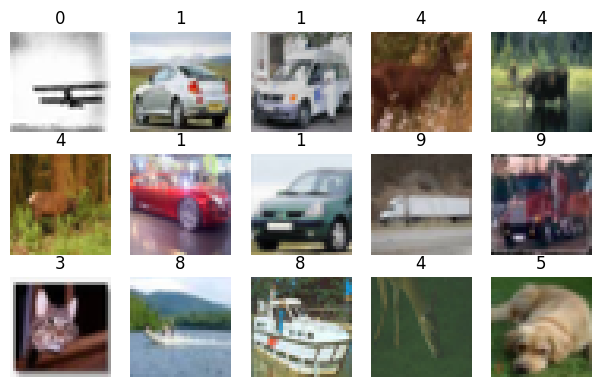

In [ ]:
def show_samples(ds,rows,cols):
    fig = plt.figure(figsize=(cols*1.5, rows*1.5))
    # plotting
    for i in range(rows*cols):
        img = ds['img'][i]
        label = ds['label'][i]
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(train_ds,rows=3,cols=5)

We are dealing with a bit different type of data comparing with original pytorch dataset. So we need to make some sort transformations and manipulations to adapt it for using with torch functions and methods.

First let's arrange our labels. Here you can notice a special type named Long which is inherent for using with NLLoss function.

In [ ]:
train_labels = [torch.tensor(x, dtype=torch.long) for x in train_ds['label']]
test_labels = [torch.tensor(x, dtype=torch.long)  for x in test_ds['label']]

Define transformations required for our images to use it with pytoch models. You can notice that except transforming PIL image to the Tensor foramt we also need to make it as a float, because original images usually are preserved as *uint8* format that we talked about on the previous lab session.

In [ ]:
transform = transforms.Compose([transforms.PILToTensor(),
                               transforms.v2.ToDtype(torch.float32, scale=True),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Applying transformations...

In [ ]:
train_torch = [transform(x) for x in train_ds['img']]
test_torch = [transform(x) for x in test_ds['img']]

Defining Dataloaders...

In [ ]:
dataset_final_train = utils.data.TensorDataset(torch.stack(train_torch), torch.stack(train_labels))
dataloader_train = DataLoader(dataset_final_train, batch_size=32)

dataset_final_test = utils.data.TensorDataset(torch.stack(test_torch), torch.stack(test_labels))
dataloader_test = DataLoader(dataset_final_test, batch_size=32)

Finally we can start training our torch model based on the tranformed Hugging Face dataset...

In [ ]:
def train(model, train_loader, test_loader, optimizer, criterion = torch.nn.NLLLoss(),
          n_epochs = 10, max_epochs_stop = 3):

    # specify loss function
    criterion = criterion

    # specify optimizer
    optimizer = optimizer

    epochs_no_improve = 0
    max_epochs_stop = max_epochs_stop
    test_loss_min = np.inf

    for epoch in range(1, n_epochs+1):

        # keep track of training and Test loss
        train_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        test_acc = 0



        # TRAIN STEP


        model.train()

        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # Calculate accuracy (don't forget to modify if you are using Cross-Enthropy and Softmax function)
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end = '\r')

        # VALIDATION STEP


        model.eval()
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average Test loss
            test_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            test_acc += accuracy.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_acc = train_acc/len(train_loader)
        test_acc = test_acc/len(test_loader)

        # print training/Test statistics
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, train_loss, test_loss))
        print(f'Training Accuracy: {100 * train_acc:.2f}%\t Test Accuracy: {100 * test_acc:.2f}%')

        # save model if Test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Continue training ...'.format(
            test_loss_min,
            test_loss))
            # torch.save(model.state_dict(), save_file)
            epochs_no_improve = 0
            test_loss_min = test_loss
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early Stopping')
                break

In [ ]:
model = CNN_advanced()

n_epochs = 20 # you may increase this number to train in a final model
optimizer = optim.Adam(model.parameters()) # Choosing optimizer. Let's choose classical Adam optimizer
# save_file_name = 'model-cifar.pt' # define name to save weights of our model

In [ ]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

In [ ]:
train(model, dataloader_train, dataloader_test, optimizer = optimizer, n_epochs = n_epochs)


Epoch: 1 	Training Loss: 2.260770 	Test Loss: 2.113657
Training Accuracy: 15.04%	 Test Accuracy: 25.89%
Test loss decreased (inf --> 2.113657).  Continue training ...
Epoch: 2 	 96.88% complete.
Epoch: 2 	Training Loss: 2.034231 	Test Loss: 1.945668
Training Accuracy: 25.00%	 Test Accuracy: 25.45%
Test loss decreased (2.113657 --> 1.945668).  Continue training ...
Epoch: 3 	 96.88% complete.
Epoch: 3 	Training Loss: 1.915303 	Test Loss: 1.914701
Training Accuracy: 30.27%	 Test Accuracy: 29.91%
Test loss decreased (1.945668 --> 1.914701).  Continue training ...

Epoch: 4 	Training Loss: 1.840770 	Test Loss: 1.893935
Training Accuracy: 33.30%	 Test Accuracy: 29.02%
Test loss decreased (1.914701 --> 1.893935).  Continue training ...
Epoch: 5 	 96.88% complete.
Epoch: 5 	Training Loss: 1.765093 	Test Loss: 1.873218
Training Accuracy: 35.94%	 Test Accuracy: 30.36%
Test loss decreased (1.893935 --> 1.873218).  Continue training ...

Epoch: 6 	Training Loss: 1.691100 	Test Loss: 1.834773
Tra

We might notive that accuracy has dropped significantly comparing with what we have received by using the full dataset.

Now let's switch to **Visual Transformers**. Let's recall its basic architecture on the image below.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

If you are a bit familiar with a context of transformers, than you probably should know that before disgesting any kind of samples (like text or images), we need something called Tokenizer for texts and Image Processors for images.

You can also notice **an image processor** is in charge of preparing input features for vision models and post processing their outputs. This includes transformations such as resizing, normalization, and conversion to PyTorch, TensorFlow, Flax and Numpy tensors. It may also include model specific post-processing such as converting logits to segmentation masks.

To apply the right transforms on our images, we will be using [ViTImageProcessor](https://discuss.huggingface.co/t/vitimageprocessor-output-visualization/76335) which will apply the transforms according to the model we will use. We can check its configuration to see what transforms will be applied. You can search an additional information about its properties and tranformations it apllies for input images.

In [ ]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

We would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
id2label[train_ds['label'][0]]

'airplane'

We can apply various **torch** transformations from the previous lab, but specifically for our **Transformer** architecrure.

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([RandomResizedCrop(size),
                             RandomHorizontalFlip(),
                             ToTensor(),
                             normalize])

_val_transforms = Compose([Resize(size),
                           CenterCrop(size),
                           ToTensor(),
                           normalize])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

Applying transformations. Don't forget that they are possible until our data is defined as the [**Dataset**](https://huggingface.co/docs/datasets/v1.2.0/processing.html) class.

In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

Making DataLoader

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=32)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


Using the special method for downloading the pretrained model

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
# image_processor  = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.weight   | MISSING    | 
classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Next Hugging Face uses **TrainingArguments**, which is a class that defines all the attributes needed for the training process. For example, we can define It a folder name, which will be used to save checkpoints, etc.

We also set the argument **remove_unused_columns** to False, because otherwise the "img" column would be removed, which is required for the data transformations.

In [ ]:


metric_name = "accuracy"


args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="tensorboard",
    # report_to='wandb'
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Preparing a special function to assess accuracy of our **transformer model.**

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

As in the previous lab we need to freeze weights of our transformer as we are intereseted to change only the **classifier layer.**

In [ ]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

All the prepared data we need to transfer to a special method called **Trainer**

In [ ]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=image_processor,
)

Start training our model...

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.285735,0.150000
2,No log,2.270229,0.195000
3,No log,2.256624,0.240000
4,No log,2.245037,0.265000
5,No log,2.235192,0.330000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.285735,0.150000
2,No log,2.270229,0.195000
3,No log,2.256624,0.240000
4,No log,2.245037,0.265000
5,No log,2.235192,0.330000


As you might notice we were able to achieve ~60% accuracy comparing with the initial CNN architecture which is a significant improvement. However, don't forget result can deviate in diefferent trials with various dataset splits or used parts for training and testing.

You check another example with that model:

https://colab.research.google.com/drive/1YELczSv8r0znzcOKJ4Lt-ecP-aNqk7NV?usp=sharing#scrollTo=xc_MTm0Ks3DF

But a main disadvantage is time that we need to train such pipeline. Obviously the main bottleneck is comlexity of the classic Multi-Head Self Attention blocks. For that purpose there was proposed **Swin Transformer**

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/c50/b87/551/c50b875512403f6399510cc736088b76.jpg)

The main feature in this architecture is Window Multi Head Attention Blocks. Basically, for each token, it assumed to calculate attention **not with all other tokens**, but only with those located in a certain window of fixed size (Window Mutli-Head Attention). This means an attention now operates in linear time! However, this approach reduces the overall representativeness of the network, since tokens from different windows will not interact in any way. To avoid this, the authors took a curious approach. After each block with Window Multi-Head Attention, they added a similar layer with **a diagonally offset Attention windows**:

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/6f6/296/77a/6f629677a902519ce7361d9988ee7446.jpg)

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/b01/d1c/894/b01d1c89427ad597bf59243701faba34.jpg)

Main advatange Swin optimizes the attention process by reducing the normally quadratic complexity VT into linear complexity (with respect to image size).



More details about [Swin Transformer](https://huggingface.co/learn/computer-vision-course/unit3/vision-transformers/swin-transformer)

Let's import necessary libraries and repeat steps we have made previously for the initital transformer model.

In [ ]:
from transformers import AutoImageProcessor, SwinForImageClassification, SwinConfig

In [ ]:
config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification")

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True)

image_processor_swin = AutoImageProcessor.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224")

In [ ]:
model

In [ ]:
metric_name = "accuracy"


args = TrainingArguments(
    f"test-cifar-10-swin",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="tensorboard",
    # report_to='wandb'
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
trainer_swin = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=image_processor,
)

In [ ]:
 for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [ ]:
trainer_swin.train()

That's it for today...

---

# **Home task**









## Task 1

You have to find two different datasets from Hugging Face library and train two different Visual Transformer-based architectures. It is up to you what architectures to choose using tags and categories provided by the library. In order to find them you can use [Hugging Face model search](https://huggingface.co/models). This is an [example](https://huggingface.co/models?pipeline_tag=image-classification&p=1&sort=trending&search=vit).

You can stick with CPU, but don't hesitate to use GPU runtime. You are allowed to use any computation environment - Colab, Kaggle, a university's cluster or your own. You can go through documentation to get to know how GPU training is done. Don't forget to provide a link with your computations in that case.


In [ ]:
# ***YOUR CODE***

## Task 2

Visual Transformers can be also used for image segmentation. You have to find a transformer model to complete the segmentation task of the provided picture. You have been provided function to show the result of the segmentation, but you can change if it is needed. A Chosen model should segment as the same or better on the provided image.


In [ ]:
from transformers import MaskFormerForInstanceSegmentation
from PIL import Image
import requests

In [ ]:

# processor = ***YOUR CODE***
# model = ***YOUR CODE***


In [ ]:
url = "https://i.pinimg.com/736x/b2/df/88/b2df88d49add10274010b248987d14a2.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

In [ ]:
num_classes = len(np.unique(predicted_semantic_map))
cmap = plt.cm.get_cmap("hsv", num_classes)

overlay = np.zeros(
    (predicted_semantic_map.shape[0], predicted_semantic_map.shape[1], 4)
)

for i, unique_value in enumerate(np.unique(predicted_semantic_map)):
    overlay[predicted_semantic_map == unique_value, :3] = cmap(i)[:3]
    overlay[predicted_semantic_map == unique_value, 3] = 0.5

fig, ax = plt.subplots(figsize=(12, 15))
ax.imshow(image)
ax.imshow(overlay, interpolation="nearest", alpha=0.9)
plt.axis("off")

plt.show()